In [32]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

In [33]:
# Set up initial variables such as S{0, 1, 2}, T{1, 2} and their deltas.

meter = 1
year = 365 * 24 * 3600
S0 = 35.0
S1, S2 = 12, 20
T1, T2 = 1, 10
DeltaT = T1 - T2
DeltaS = S1 - S2
time_max = 10000 * year
alpha = 0.2 # (kg/m^3) K^-1
beta = 0.8 # (kg/m^3) ppt^-1
k = 10e9 # (m^3/s)/(kg/m^3) # 3e-8; # sec^-1
# area of each of the ocean boxes, rediculous value, needed to get
# all other results at the right order of magnitude:
area = (50000.0e3) ** 2
depth = 4000
V = area * depth # volume of each of the ocean boxes
Sv = 1.e9 # m^3/sec

In [34]:
class BoxModel:
    def __init__(self, S0, S1, S2, T1, T2, alpha, beta, k, area, depth):
        self.S0 = S0
        self.S1 = S1
        self.S2 = S2
        self.T1 = T1
        self.T2 = T2
        self.alpha = alpha
        self.beta = beta
        self.k = k
        self.area = area
        self.depth = depth

    @property
    def DeltaT(self):
        return self.T1 - self.T2

    @property
    def DeltaS(self):
        return self.S1 - self.S2

    def q(self, DeltaT, DeltaS):
        """Implements the AMOC volume transport q."""
        # THC transport in m^3/sec as function of temperature and salinity
        # difference between the boxes
        
        rho_1_2_diff = alpha * DeltaT - beta * DeltaS
        flow = self.k * rho_1_2_diff
        
        return flow

    def d_q_t(self):
        """Implements the analytical derivative of q wrt. t."""
        return -self.k * self.beta * 2 * (self.F - abs(self.q()) * self.DeltaS)

    def steady_states(self, F, X):
        """Implements the steady state solutions of the model."""
        Y = np.zeros((3,))
    
        y1 = (X - np.sqrt(X**2 + 4 * self.beta * F / self.k)) / 2
        val = X**2 - 4 * self.beta * F / self.k
    
        # The argument to the square root function has to be positive.
        if val > 0:
            offset = X / 2
            y2 = offset + np.sqrt(val) / 2
            y3 = offset - np.sqrt(val) / 2
        # Simply set the solution to NaN if the argument is non-positive.
        else:
            y2 = np.nan
            y3 = np.nan
        
        Y = np.array([y1, y2, y3])
        return Y

    def Fs_func(self, time, time_max, is_Fs_time_dependent):
        # total surface salt flux into northern box
        # Specify maximum and minimum of freshwater forcing range during the
        # run in m/year:
        FW_min = -0.1
        FW_max = 5
    
        if is_Fs_time_dependent:
            flux = FW_min + (FW_max - FW_min) * time / time_max
        else:
            flux = 2
    
        # convert to total salt flux:
        return flux * area * S0 / year

    def simulate(self, Fs_range):
        # Compute the steady state solutions as well as the q values for the above values of F.
        DeltaS_steady = np.zeros((3, len(Fs_range)))
        q_steady = np.zeros((3, len(Fs_range)))
        
        for i, Fs in enumerate(Fs_range):
            Y = model.steady_states(Fs, model.alpha * model.DeltaT)
            # translate Y solution to a solution for DeltaS:
            DeltaS_steady[:, i] = Y / model.beta
            for j in range(3):
                q_steady[j, i] = model.q(DeltaT, DeltaS_steady[j, i])

        return DeltaS_steady, q_steady

In [35]:
Fs_range = np.arange(0, 5, 0.01) * area * S0 / year
model = BoxModel(S0, S1, S2, T1, T2, alpha, beta, k, area, depth)
DeltaS_steady, q_steady = model.simulate(Fs_range)

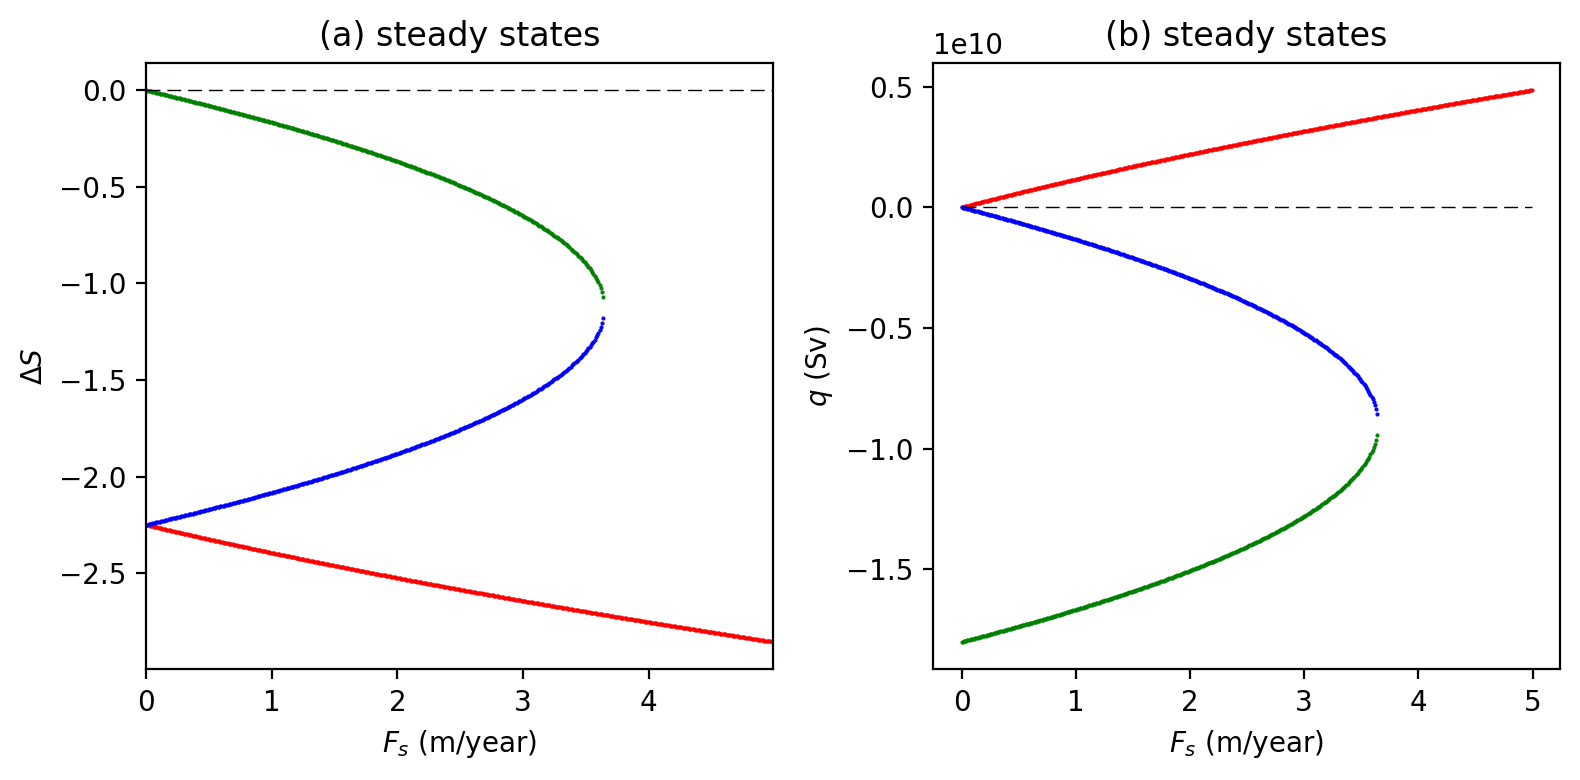

In [36]:
# Generate some plots.
# This sort of validates the correctness of the implementation since the plots are the same
# as in the textbook.

plt.figure(1, figsize=(8, 4), dpi=200)
Fs_to_m_per_year = S0 * area / year
Fs_range_normalized = Fs_range / Fs_to_m_per_year

plt.subplot(1, 2, 1)
# plot all three solutions for Delta S as function of Fs in units of m/year:
plt.plot(Fs_range_normalized, DeltaS_steady[0, :], 'r.', markersize=1)
plt.plot(Fs_range_normalized, DeltaS_steady[1, :], 'g.', markersize=1)
plt.plot(Fs_range_normalized, DeltaS_steady[2, :], 'b.', markersize=1)

# plot a dash think line marking the zero value:
plt.plot(Fs_range_normalized, np.zeros(DeltaS_steady.shape[1]), 'k--', dashes=(10, 5), linewidth=0.5)
plt.title('(a) steady states')
plt.xlabel('$F_s$ (m/year)');
plt.ylabel('$\Delta S$');
plt.xlim([min(Fs_range_normalized), max(Fs_range_normalized)])

plt.subplot(1, 2, 2)
# plot all three solutions for q (in Sv) as function of Fs in units of m/year:
plt.plot(Fs_range_normalized, q_steady[0, :], 'r.', markersize=1)
plt.plot(Fs_range_normalized, q_steady[1, :], 'g.', markersize=1)
plt.plot(Fs_range_normalized, q_steady[2, :], 'b.', markersize=1)
plt.plot(Fs_range_normalized, np.zeros(q_steady.shape[1]), 'k--', dashes=(10, 5), linewidth=0.5)
plt.title('(b) steady states')
plt.xlabel('$F_s$ (m/year)')
plt.ylabel('$q$ (Sv)')
plt.tight_layout()
plt.show()